In [44]:
!pip install inflect

In [ ]:
import nltk
nltk.download('stopwords')

In [271]:
import nltk
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout
from keras.layers import InputLayer
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

#!spell login #henmja, a****

In [277]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_pickle("bigdataClean.pkl")
df.tail()

,contributors_enabled_user,created_at,created_at_user,default_profile_image_user,default_profile_user,description_user,display_url_zero_urls_entities,display_url_zero_urls_url_entities_user,expanded_url_zero_urls_entities,expanded_url_zero_urls_url_entities_user,favorite_count,favorited,favourites_count_user,follow_request_sent_user,followers_count_user,following_user,friends_count_user,geo_enabled_user,has_extended_profile_user,id,id_str,id_str_user,id_str_zero_user_mentions_entities,id_user,id_zero_user_mentions_entities,is_quote_status,is_translation_enabled_user,is_translator_user,lang,listed_count_user,location_user,name_user,name_zero_user_mentions_entities,notifications_user,possibly_sensitive,possibly_sensitive_appealable,profile_background_color_user,profile_background_image_url_https_user,profile_background_image_url_user,profile_background_tile_user,profile_banner_url_user,profile_image_url_https_user,profile_image_url_user,profile_link_color_user,profile_sidebar_border_color_user,profile_sidebar_fill_color_user,profile_text_color_user,profile_use_background_image_user,protected_user,retweet_count,retweeted,screen_name_user,screen_name_zero_user_mentions_entities,source,statuses_count_user,text,translator_type_user,truncated,url_user,url_zero_urls_entities,url_zero_urls_url_entities_user,verified_user,zero_indices_zero_urls_entities,one_indices_zero_urls_entities,zero_indices_zero_urls_url_entities_user,one_indices_zero_urls_url_entities_user,zero_indices_zero_user_mentions_entities,one_indices_zero_user_mentions_entities,followers,following,label
788,False,2017-05-20 14:11:39+00:00,Sun Oct 25 14:01:48 +0000 2009,False,True,,fb.me/1fYsjNaLC,thekind-heartedsmartaleck.blogspot.com,http://fb.me/1fYsjNaLC,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,16.0,False,47.0,False,87.0,True,True,8.659330e+17,8.659330e+17,85085807,10228272,8.508581e+07,8.529181e+16,False,False,False,en,7.0,Gassaway WV,Terry Bly,YouTube,False,False,False,C0DEED,https://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/13552184...,https://pbs.twimg.com/profile_images/249393875...,http://pbs.twimg.com/profile_images/2493938757...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,TlbBly,YouTube,"<a href=""http://www.facebook.com/twitter"" rel=...",90486.0,WORSE THAN HITLER! Trey Gowdy’s Son Found In A...,none,False,None,https://t.co/dxpndRqHjL,http://t.co/PYrnTHpCvI,False,93.0,116.0,0.0,22.545205,49.264865,60.043243,"1093777852477116417, 936194589043683328, 10472...","1093777852477116417, 936194589043683328, 10472...",fake
789,False,2017-12-09 09:10:03+00:00,Wed Feb 24 22:58:57 +0000 2016,False,True,PROUD PATRIOT SUPPORTING TRUMP!! PRO-AMERICAN....,twitter.com/i/web/status/9…,thekind-heartedsmartaleck.blogspot.com,https://twitter.com/i/web/status/9394218766187...,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,74641.0,False,6903.0,False,4533.0,True,True,9.394219e+17,9.394219e+17,702628810483765249,10228272,7.026288e+17,8.529181e+16,False,False,False,en,86.0,"Orlando, FL",#TRUMP2020,YouTube,False,False,False,F5F8FA,None,None,False,https://pbs.twimg.com/profile_banners/70262881...,https://pbs.twimg.com/profile_images/111902430...,http://pbs.twimg.com/profile_images/1119024306...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,PolyPatriot,YouTube,"<a href=""http://twitter.com/download/iphone"" r...",155849.0,Facebook Picks Sides in Alabama Senate Race=&g...,none,True,None,https://t.co/o4Qq2UFraj,http://t.co/PYrnTHpCvI,False,120.0,143.0,0.0,22.545205,49.264865,60.043243,,,fake
790,False,2017-08-29 17:54:38+00:00,Tue Sep 15 02:55:59 +0000 2009,False,True,,houstonchronicle-tv.com/floyd-mayweath…,thekind-heartedsmartaleck.blogspot.com,http://houstonchronicle-tv.com/floyd-mayweathe...,http://thekind-heartedsmartaleck.blogspot.com/,1.0,False,11.0,False,24.0,False,42.0,True,False,9.025903e+17,9.025903e+17,74346965,10228272,7.434696e+07,8.529181e+16,False,Fa

In [278]:
uniqueIDs = {}
IDrange = 0
#add words for each id in df
for i, ids in enumerate(df['followers']):
    print(i)
    try:
        ids = [int(x) for x in ids.split(', ')]
        for ID in ids:
            if ID not in uniqueIDs.keys():
                uniqueIDs[ID] = IDrange
                IDrange = IDrange+1
    except ValueError:
        pass
    except AttributeError:
        pass
    except TypeError:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [279]:

#print unique ids
#fjern break
import inflect
p = inflect.engine()
#add words for each id in df
for i, ids in enumerate(df['followers']):
    print(i)
    try:
        ids = [int(x) for x in ids.split(', ')]
    except ValueError:
        ids = []
    except AttributeError:
        ids = []
    except TypeError:
        ids = []
    df['followers'][i] = []
    for j, ID in enumerate(ids):
        #convert ids to list
        try:
            df['followers'][i].append(uniqueIDs[ID]) 
            df['followers'][i][j] = p.number_to_words(df['followers'][i][j])
        except ValueError:
            pass
        except AttributeError:
            pass
        except TypeError:
            pass
    df['followers'][i].sort()

0


C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [280]:
uniqueIDs = {}
IDrange = 0
#add words for each id in df
for i, ids in enumerate(df['following']):
    print(i)
    try:
        ids = [int(x) for x in ids.split(', ')]
        for ID in ids:
            if ID not in uniqueIDs.keys():
                uniqueIDs[ID] = IDrange
                IDrange = IDrange+1
    except ValueError:
        pass
    except AttributeError:
        pass
    except TypeError:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [281]:
import inflect
p = inflect.engine()
#add words for each id in df
for i, ids in enumerate(df['following']):
    print(i)
    try:
        ids = [int(x) for x in ids.split(', ')]
    except ValueError:
        ids = []
    except AttributeError:
        ids = []
    except TypeError:
        ids = []
    df['following'][i] = []
    for j, ID in enumerate(ids):
        #convert ids to list
        try:
            df['following'][i].append(uniqueIDs[ID]) 
            df['following'][i][j] = p.number_to_words(df['following'][i][j])
        except ValueError:
            pass
        except AttributeError:
            pass
        except TypeError:
            pass
    df['following'][i].sort()

0


C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [282]:
df['followers'] = df['followers'].astype(str)
df['following'] = df['following'].astype(str) 
try:
    for row in df['following'].keys(): 
        df['following'][row] = df['following'][row].strip('][')
    for row in df['followers'].keys():
        df['followers'][row] = df['followers'][row].strip('][')
except ValueError:
    pass
df['created_at'] = df['created_at'].astype(str)
df.tail()
#https://datascience.stackexchange.com/questions/67145/word-embedding-or-hash

#drop followers og following
#cdf - fake different users, real users tweet more regularly
#scatterplot - ratio
#plot retweet
#remove stopwords before plotting
#scatter plot - followers/following
#remove empty text rows
#retweet time per article
#normalize numeric values
#http://digital-thinking.de/deep-learning-combining-numerical-and-text-features-in-deep-neural-networks/
#concatenate numeric values og kjør LSTM med to inputs
#increase Sequence length med antall attributes og embed numeric attributes og bruk sequential hvis to inputs ikke går.
#word embedding av bigdataClean og LSTM. Order followers før embedding? (gloves er trent til å behandle ord som tall)
#prøve uten normalize?

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,contributors_enabled_user,created_at,created_at_user,default_profile_image_user,default_profile_user,description_user,display_url_zero_urls_entities,display_url_zero_urls_url_entities_user,expanded_url_zero_urls_entities,expanded_url_zero_urls_url_entities_user,favorite_count,favorited,favourites_count_user,follow_request_sent_user,followers_count_user,following_user,friends_count_user,geo_enabled_user,has_extended_profile_user,id,id_str,id_str_user,id_str_zero_user_mentions_entities,id_user,id_zero_user_mentions_entities,is_quote_status,is_translation_enabled_user,is_translator_user,lang,listed_count_user,location_user,name_user,name_zero_user_mentions_entities,notifications_user,possibly_sensitive,possibly_sensitive_appealable,profile_background_color_user,profile_background_image_url_https_user,profile_background_image_url_user,profile_background_tile_user,profile_banner_url_user,profile_image_url_https_user,profile_image_url_user,profile_link_color_user,profile_sidebar_border_color_user,profile_sidebar_fill_color_user,profile_text_color_user,profile_use_background_image_user,protected_user,retweet_count,retweeted,screen_name_user,screen_name_zero_user_mentions_entities,source,statuses_count_user,text,translator_type_user,truncated,url_user,url_zero_urls_entities,url_zero_urls_url_entities_user,verified_user,zero_indices_zero_urls_entities,one_indices_zero_urls_entities,zero_indices_zero_urls_url_entities_user,one_indices_zero_urls_url_entities_user,zero_indices_zero_user_mentions_entities,one_indices_zero_user_mentions_entities,followers,following,label
788,False,2017-05-20 14:11:39+00:00,Sun Oct 25 14:01:48 +0000 2009,False,True,,fb.me/1fYsjNaLC,thekind-heartedsmartaleck.blogspot.com,http://fb.me/1fYsjNaLC,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,16.0,False,47.0,False,87.0,True,True,8.659330e+17,8.659330e+17,85085807,10228272,8.508581e+07,8.529181e+16,False,False,False,en,7.0,Gassaway WV,Terry Bly,YouTube,False,False,False,C0DEED,https://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/13552184...,https://pbs.twimg.com/profile_images/249393875...,http://pbs.twimg.com/profile_images/2493938757...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,TlbBly,YouTube,"<a href=""http://www.facebook.com/twitter"" rel=...",90486.0,WORSE THAN HITLER! Trey Gowdy’s Son Found In A...,none,False,None,https://t.co/dxpndRqHjL,http://t.co/PYrnTHpCvI,False,93.0,116.0,0.0,22.545205,49.264865,60.043243,"'fifty-seven thousand, five hundred and fifty'...","'fifty-seven thousand, five hundred and fifty'...",fake
789,False,2017-12-09 09:10:03+00:00,Wed Feb 24 22:58:57 +0000 2016,False,True,PROUD PATRIOT SUPPORTING TRUMP!! PRO-AMERICAN....,twitter.com/i/web/status/9…,thekind-heartedsmartaleck.blogspot.com,https://twitter.com/i/web/status/9394218766187...,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,74641.0,False,6903.0,False,4533.0,True,True,9.394219e+17,9.394219e+17,702628810483765249,10228272,7.026288e+17,8.529181e+16,False,False,False,en,86.0,"Orlando, FL",#TRUMP2020,YouTube,False,False,False,F5F8FA,None,None,False,https://pbs.twimg.com/profile_banners/70262881...,https://pbs.twimg.com/profile_images/111902430...,http://pbs.twimg.com/profile_images/1119024306...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,PolyPatriot,YouTube,"<a href=""http://twitter.com/download/iphone"" r...",155849.0,Facebook Picks Sides in Alabama Senate Race=&g...,none,True,None,https://t.co/o4Qq2UFraj,http://t.co/PYrnTHpCvI,False,120.0,143.0,0.0,22.545205,49.264865,60.043243,,,fake
790,False,2017-08-29 17:54:38+00:00,Tue Sep 15 02:55:59 +0000 2009,False,True,,houstonchronicle-tv.com/floyd-mayweath…,thekind-heartedsmartaleck.blogspot.com,http://houstonchronicle-tv.com/floyd-mayweathe...,http://thekind-heartedsmartaleck.blogspot.com/,1.0,False,11.0,False,24.0,False,42.0,True,False,9.025903e+17,9.025903e+17,74346965,10228272,7.434696e+07,8.529181e+16,False,Fa

In [283]:
#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'source', 'display_url_zero_urls_entities', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'display_url_zero_urls_url_entities_user', 'expanded_url_zero_urls_entities', 'expanded_url_zero_urls_url_entities_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_image_url_https_user', 'profile_background_image_url_user', 'profile_background_tile_user', 'profile_banner_url_user', 'profile_image_url_https_user', 'profile_image_url_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'url_user', 'url_zero_urls_entities', 'url_zero_urls_url_entities_user', 'verified_user']
xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_tile_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user', 'followers', 'following']
#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_tile_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user', 'followers', 'following']
x = 'created_at: ' + df['created_at'] + ' - text: ' + df['text']
i = 0
for col in xCols:
    df[col] = df[col].astype(str)
for idx in xCols:
    if i>1:
        x = x + ' - ' + str(idx) + ': ' + df[idx]
    i=i+1
#x = df[xCols].apply(lambda row: .join(row.values.astype(str)), axis=1)
print(x[0])

created_at: 2015-10-09 21:18:53+00:00 - text: Missed @marcorubio in NH this week? Come to a town hall meeting in Derry on Wednesday. #fitn #nhpolitics #nhformarco https://t.co/FlrKPldQ76 - created_at_user: Fri Jun 27 23:15:54 +0000 2014 - name_user: Paige Johnson - name_zero_user_mentions_entities: Marco Rubio - location_user: Jericho, NY - description_user: Sagittarius♐️ | @darrencriss🕶 | Demi Lovato💖 | Board of Directors @NHLogCabin🏳️‍🌈 | All opinions are my own. - contributors_enabled_user: False - default_profile_image_user: False - default_profile_user: False - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: True - has_extended_profile_user: True - id: 6.525941018802668e+17 - id_str: 6.525941018802668e+17 - id_str_user: 2592090978 - id_str_zero_user_mentions_entities: 15745368 - id_user: 2592090978.0 - id_zero_user_mentions_entities: 15745368.0 - is_quote_status: False - is_translation_enabled_user: False - is_translator_user: False -

In [284]:
num_Cols = ['favorite_count', 'favourites_count_user', 'followers_count_user', 'friends_count_user', 'listed_count_user', 'retweet_count', 'statuses_count_user', 'zero_indices_zero_urls_entities', 'one_indices_zero_urls_entities', 'zero_indices_zero_urls_url_entities_user', 'one_indices_zero_urls_url_entities_user', 'zero_indices_zero_user_mentions_entities', 'one_indices_zero_user_mentions_entities']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [287]:
print(y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [288]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = 'glove.6B.'+str(EMBEDDING_DIM)+'d.txt'

In [289]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
    text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
    text = str(text).replace(r'\.',' . ') #replace periods with a single one
    text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
    text = str(text).replace('\n', '') #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts
    if remove_stopwords:
        text = text.split(' ')
    for word in text:
        if word not in stopwords.words('english'):
            output = output + " " + word
        #else:
            #output = text
            #print(word)
    return str(output.strip())[1:-3].replace(' ', ' ')

In [290]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [291]:
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
    texts.append(clean_text(line))

In [292]:
print('Sample data:', texts[0], y[0])

Sample data: reated_at 20151009 2118530000  text missed marcorubio nh week come town hall meeting derry wednesday fitn nhpolitics nhformarco httpstcoflrkpldq76  created_at_user fri jun 27 231554 0000 2014  name_user paige johnson  name_zero_user_mentions_entities marco rubio  location_user jericho ny  description_user sagittarius  darrencriss  demi lovato  board directors nhlogcabin  opinions  contributors_enabled_user false  default_profile_image_user false  default_profile_user false  favorited false  follow_request_sent_user false  following_user false  geo_enabled_user true  has_extended_profile_user true  id 6525941018802668e17  id_str 6525941018802668e17  id_str_user 2592090978  id_str_zero_user_mentions_entities 15745368  id_user 25920909780  id_zero_user_mentions_entities 157453680  is_quote_status false  is_translation_enabled_user false  is_translator_user false  lang en  location_user jericho ny  name_user paige johnson  notifications_user false  possibly_sensitive false  po

In [293]:
#encode text as numbers
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 14628


In [294]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (793, 1000)
Shape of label tensor: (793, 2)


In [295]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [296]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [307 328]
validation:  [78 80]


In [297]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 58   5   1  10   2   4   1  43   5   1  42   2   8   1   6   5   1  42
   2   8   1  95   5   1  42   2   7   1  33   5   1  42   2   7   1 100
   5   1  42   2   7   1  96   5   1  42   2   6   1  59   5   1  42   2
   6   1  83   5   1  42   2   9   1  95   5   1  42   2   9   1  83   5
   1  42   2  10   1  98   5   1  42   2  10   1  77   5   1  42   2   5
   1   7   5   1  28   2   7   1  90   5   1  28   2   3   1  85   5   1
  12   2  10   1  24   5   1  31   2   3   1  68   5   1  37   2  45   5
   1  27   5   1  27   2   6   1  57   5   1  27   2   9   1  15   5   1
  27   2   9   1  90   5   1  27   2   5   1  80   5   1  29   2   9   1
  47   5   1  29   2  10   1 101   5   1   5   2   7   1  23   5   1   5
   2   9   1  12   5   1  24   2   8   1  77   5   1  24   2   4   1  97
   5   1  93   2  11   5   1  93   2  71   5   1  93   2   9   1  46   5
   1  93   2  11   1  14   5   1  93   2  11   1  44   5   1  93   2  10
   1  63   5   1  93   2  10

In [298]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…Completed!


In [308]:

model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH,),dtype='int32'))
e = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
model.add(e)
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
          

In [309]:
model.compile(optimizer='adam', loss='binary_crossentropy',
 metrics = ['accuracy'])

In [310]:
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_val, y_val))
#val acc = 0.9177
#uten urls - val acc = 0.9494, batch 128
#uten urls - val acc = 0.85, batch 192
#uten urls - val acc = 0.9652, batch 64
#uten urls og fargekoder - val acc = 0.9684,batch 128
#uten urls og fargekoder - val acc = 0.9462,batch 64
#uten urls og fargekoder - val acc = 0.9272,batch 192
#uten boolean urls og fargekoder - val acc = 0.9272, batch 128
#uten boolean urls og fargekoder - val acc = 0.9272, batch 192
#uten boolean urls og fargekoder - val acc = 0.9430, batch 64
#uten created urls og fargekoder - val acc = 0.9304, batch 192
#uten created urls og fargekoder - val acc = 0.9430, batch 128
#uten created urls og fargekoder - val acc = 0.9304, batch 64
#uten id urls og fargekoder - val acc = 0.9241, batch 192
#uten id urls og fargekoder - val acc = 0.9177, batch 128
#uten id urls og fargekoder - val acc = 0.9367, batch 64
#uten str urls og fargekoder - val acc = 0.8576, batch 192
#uten str urls og fargekoder - val acc = 0.8481, batch 128
#uten str urls og fargekoder - val acc = 0.8861, batch 64
#med followers og following - val acc = 0.9304, batch 192
#med followers og following - val acc = 0.9367, batch 128
#med followers og following - val acc = 0.9335, batch 64

Train on 635 samples, validate on 158 samples
Epoch 1/20
635/635 [==============================] - ETA: 2:35 - loss: 0.6926 - acc: 0.578 - ETA: 1:19 - loss: 0.7030 - acc: 0.484 - ETA: 54s - loss: 0.6978 - acc: 0.510 - ETA: 41s - loss: 0.6996 - acc: 0.48 - ETA: 34s - loss: 0.6967 - acc: 0.49 - ETA: 28s - loss: 0.6973 - acc: 0.49 - ETA: 24s - loss: 0.6966 - acc: 0.50 - ETA: 20s - loss: 0.6973 - acc: 0.50 - ETA: 17s - loss: 0.6986 - acc: 0.49 - ETA: 15s - loss: 0.6993 - acc: 0.48 - ETA: 13s - loss: 0.6980 - acc: 0.49 - ETA: 11s - loss: 0.6988 - acc: 0.49 - ETA: 9s - loss: 0.6972 - acc: 0.5048 - ETA: 7s - loss: 0.6954 - acc: 0.514 - ETA: 6s - loss: 0.6959 - acc: 0.512 - ETA: 4s - loss: 0.6968 - acc: 0.504 - ETA: 3s - loss: 0.6973 - acc: 0.501 - ETA: 2s - loss: 0.6962 - acc: 0.506 - ETA: 1s - loss: 0.6966 - acc: 0.504 - 24s 38ms/step - loss: 0.6970 - acc: 0.5031 - val_loss: 0.6854 - val_acc: 0.5348
Epoch 2/20
635/635 [==============================] - ETA: 14s - loss: 0.6963 - acc: 0.42 - 

635/635 [==============================] - ETA: 11s - loss: 0.2310 - acc: 0.87 - ETA: 11s - loss: 0.2360 - acc: 0.89 - ETA: 10s - loss: 0.2491 - acc: 0.87 - ETA: 9s - loss: 0.2215 - acc: 0.9023 - ETA: 9s - loss: 0.2240 - acc: 0.896 - ETA: 8s - loss: 0.2091 - acc: 0.914 - ETA: 7s - loss: 0.2076 - acc: 0.912 - ETA: 7s - loss: 0.2051 - acc: 0.914 - ETA: 6s - loss: 0.2111 - acc: 0.908 - ETA: 5s - loss: 0.2103 - acc: 0.906 - ETA: 5s - loss: 0.2044 - acc: 0.913 - ETA: 4s - loss: 0.2060 - acc: 0.912 - ETA: 4s - loss: 0.2127 - acc: 0.908 - ETA: 3s - loss: 0.2071 - acc: 0.911 - ETA: 2s - loss: 0.2146 - acc: 0.909 - ETA: 2s - loss: 0.2229 - acc: 0.906 - ETA: 1s - loss: 0.2192 - acc: 0.909 - ETA: 1s - loss: 0.2224 - acc: 0.907 - ETA: 0s - loss: 0.2261 - acc: 0.907 - 13s 20ms/step - loss: 0.2235 - acc: 0.9094 - val_loss: 0.2498 - val_acc: 0.8766
Epoch 11/20
635/635 [==============================] - ETA: 11s - loss: 0.1575 - acc: 0.96 - ETA: 11s - loss: 0.1746 - acc: 0.95 - ETA: 10s - loss: 0.2030

635/635 [==============================] - ETA: 11s - loss: 0.0736 - acc: 0.96 - ETA: 10s - loss: 0.0891 - acc: 0.96 - ETA: 10s - loss: 0.1078 - acc: 0.97 - ETA: 10s - loss: 0.0940 - acc: 0.98 - ETA: 9s - loss: 0.1037 - acc: 0.9750 - ETA: 9s - loss: 0.1091 - acc: 0.968 - ETA: 8s - loss: 0.1176 - acc: 0.964 - ETA: 7s - loss: 0.1386 - acc: 0.960 - ETA: 7s - loss: 0.1283 - acc: 0.965 - ETA: 6s - loss: 0.1287 - acc: 0.965 - ETA: 5s - loss: 0.1233 - acc: 0.968 - ETA: 5s - loss: 0.1250 - acc: 0.967 - ETA: 4s - loss: 0.1191 - acc: 0.970 - ETA: 3s - loss: 0.1200 - acc: 0.967 - ETA: 3s - loss: 0.1165 - acc: 0.969 - ETA: 2s - loss: 0.1116 - acc: 0.971 - ETA: 1s - loss: 0.1205 - acc: 0.968 - ETA: 1s - loss: 0.1226 - acc: 0.967 - ETA: 0s - loss: 0.1192 - acc: 0.968 - 14s 22ms/step - loss: 0.1199 - acc: 0.9677 - val_loss: 0.2935 - val_acc: 0.8829
Epoch 20/20
635/635 [==============================] - ETA: 15s - loss: 0.2595 - acc: 0.87 - ETA: 13s - loss: 0.1508 - acc: 0.93 - ETA: 13s - loss: 0.1385

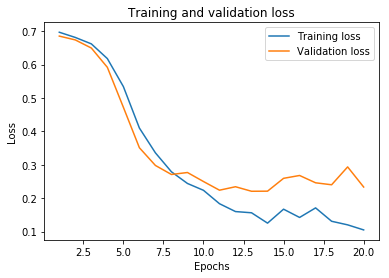

In [311]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

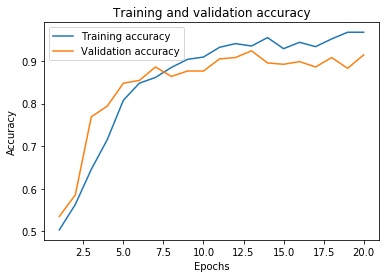

In [312]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [313]:
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [314]:
prediction = model.predict(test_data_padded)

In [315]:
test_label

array([0, 1], dtype=uint8)

In [316]:
prediction[random_num].argsort()[-len(prediction[random_num]):]

array([0, 1], dtype=int64)

In [317]:
test_data

"created_at: 2009-09-24 06:09:22+00:00 - text: Popular NOW: School kids taught to sing the praise of Obama #video http://tinyurl.com/l3yxmg\nhttp://truveo.com/most-twittered-videos - created_at_user: Mon Sep 15 18:11:46 +0000 2008 - name_user: Truveo - name_zero_user_mentions_entities: PolitiFact - location_user: San Francisco, California - description_user: Looking for the most popular videos on the web? You'll find them here at http://t.co/54FgegMQt6. - contributors_enabled_user: False - default_profile_image_user: False - default_profile_user: True - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: False - has_extended_profile_user: False - id: 4336097933.0 - id_str: 4336097933.0 - id_str_user: 16299137 - id_str_zero_user_mentions_entities: 8953122 - id_user: 16299137.0 - id_zero_user_mentions_entities: 8.529181491926525e+16 - is_quote_status: False - is_translation_enabled_user: False - is_translator_user: False - lang: en - location_us

In [ ]:
input1 = Input(shape=(MAX_SEQ_LENGTH,), name='nlp_input') #TEXT
input2 = Input(shape=(10,), name='meta_input') #NON-TEXT ATTRS
emb = Embedding(output_dim=len(word_index) + 1, input_dim=EMBEDDING_DIM, weights = [embedding_matrix], 
                input_length=MAX_SEQ_LENGTH, 
                trainable=False, 
                name = ‘embeddings’)))(input1)
input1_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
merged = keras.layers.Concatenate(axis=1)([input1_out, input2])
maxpool = keras.layers.GlobalMaxPool1D()(merged)
dropout1 = keras.layers.Dropout(0.1)(maxpool)
dense1 = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dropout1)
dropout2 = keras.layers.Dropout(0.1)(dense1)
dense2 = keras.layers.Dense(2, input_dim=2, activation=keras.activations.sigmoid, use_bias=True)(dropout2)
model10 = keras.models.Model(inputs=[input1, input2], output=output)
model10.compile(optimizer=’adam’, loss=’binary_crossentropy’,
metrics = ['accuracy')
history = model0.fit([x_train, CAT_ATTRS],y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val))                                     
                
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history[‘loss’]
val_loss = history.history[‘val_loss’]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label=’Training loss’)
plt.plot(epochs, val_loss, label=’Validation loss’)
plt.title(‘Training and validation loss’)
plt.xlabel(‘Epochs’)
plt.ylabel(‘Loss’)
plt.legend()
plt.show();
                
accuracy = history.history[‘acc’]
val_accuracy = history.history[‘val_acc’]
plt.plot(epochs, accuracy, label=’Training accuracy’)
plt.plot(epochs, val_accuracy, label=’Validation accuracy’)
plt.title(‘Training and validation accuracy’)
plt.ylabel(‘Accuracy’)
plt.xlabel(‘Epochs’)
plt.legend()
plt.show();
                
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = ‘post’, maxlen = MAX_SEQUENCE_LENGTH)
                
prediction = model.predict(test_data_padded)
                
prediction[random_num].argsort()[-len(prediction[random_num]):]